# Creating Spectral Data Cubes from Galaxy Particle distributions

In this example we show how to create a spectral data cube from stellar particles. For this purpose we need a stellar distribution and a galaxy. The first section will handle this setup using a CAMELS galaxy, feel free to skip over this section to get to the spectral data cube synthesis as the process is well documented elsewhere (e.g. the CAMELS [docs](../cosmo/cosmo_example.ipynb)).

## The setup

In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, angstrom
from astropy.cosmology import Planck18 as cosmo
from scipy import signal

from synthesizer.grid import Grid
from synthesizer.imaging import SpectralCube
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel

Before we do anything we need an SPS grid from which to derive spectra.

In [2]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

In this example we will use one of the CAMELS galaxies from the test data. For details on making your own galaxies see [the particle galaxy docs](../galaxies/galaxy_obj.ipynb).

In [3]:
galaxy_start = time.time()

# Create galaxy object
gal = load_CAMELS_IllustrisTNG(
    "../../../tests/data/",
    snap_name="camels_snap.hdf5",
    fof_name="camels_subhalo.hdf5",
    physical=True,
)[0]

print("Galaxy created, took:", time.time() - galaxy_start)

print(f"Galaxy has {gal.stars.nstars} stellar particles")
print(f"Galaxy gas {gal.gas.nparticles} gas particles")

Galaxy created, took: 0.02058696746826172
Galaxy has 473 stellar particles
Galaxy gas 0 gas particles


/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Now we have a galaxy we can derive spectra. For this example we'll use reprocessed spectra (see the spectra [docs](../sed.ipynb)). Once we have the spectra we will convert from spectral luminosity density to spectral flux density.

In [4]:
spectra_start = time.time()

# Calculate the stellar rest frame SEDs for all particles in erg / s / Hz
sed = gal.stars.get_particle_spectra_reprocessed(grid)

# Calculate the observed SED in nJy
sed.get_fnu(cosmo, gal.redshift)

print("Spectra created, took:", time.time() - spectra_start)

Spectra created, took: 0.23039913177490234


## Spectral Data Cube Creation

We now have most of the ingredients we need to generate a spectral data cube from our galaxy. The only parts that are missing are the wavelength array of our spectral data cube, its resolution and FOV, and a kernel for smoothing particles over. We'll define these below and move on to making the spectral data cube.

In [5]:
# Define the width of the image
width = 30 * kpc

# Define image resolution (here we arbitrarily set it to 100 pixels along an axis)
resolution = width / 200

# Define the wavelength array
lam = np.linspace(10**3.5, 10**4.5, 1000)

print(
    "Data cube spatial width is %.2f kpc with a %.2f kpc spaxel resolution"
    % (width.value, resolution.value)
)

# Get the SPH kernel
kernel = Kernel()
kernel_data = kernel.get_kernel()

Data cube spatial width is 30.00 kpc with a 0.15 kpc spaxel resolution


Synthesizer allows you to make either a "2D histogram" data cube, where particles are sorted into individual pixels, or data cubes where particles are smoothed over their SPH kernels. We'll focus on the latter, but to do the former you simply call `get_data_cube_hist` with an `sed`, `coordinates` and the `Sed` quantity you want to populate the data cube with.

To make a smoothed data cube we will must first instantiate the `SpectralCube` and then call `get_data_cube_smoothed` which takes a `sed`, `coordinates`, `smoothing_lengths`, a `kernel`, the threshold of the `kernel` and the `Sed` quantity you want to populate the data cube with. The possible quantities are `"lnu"`, `"luminosity"` or `"llam"` for rest frame luminosities, or `"fnu"`, `"flam"` or `"flux"` for fluxes (the latter 3 require `get_fnu` or `get_fnu0` to have been called). We will make a cube populated with `"fnu"`, i.e. the spectral flux density.

In [6]:
cube_start = time.time()

# Get the data cube
cube = SpectralCube(resolution=resolution, lam=lam, fov=width)

# And get the cube itself
cube.get_data_cube_smoothed(sed, coordinates=gal.stars.coordinates, smoothing_lengths=gal.stars.smoothing_lengths, kernel=kernel_data, kernel_threshold=1, quantity="fnu")

print("Spectral data cube created, took:", time.time() - cube_start)

Spectral data cube created, took: 1.4184653759002686


And that's it. We now have a spectral data cube to analyse. We can visualise the data cube by making an animation. 

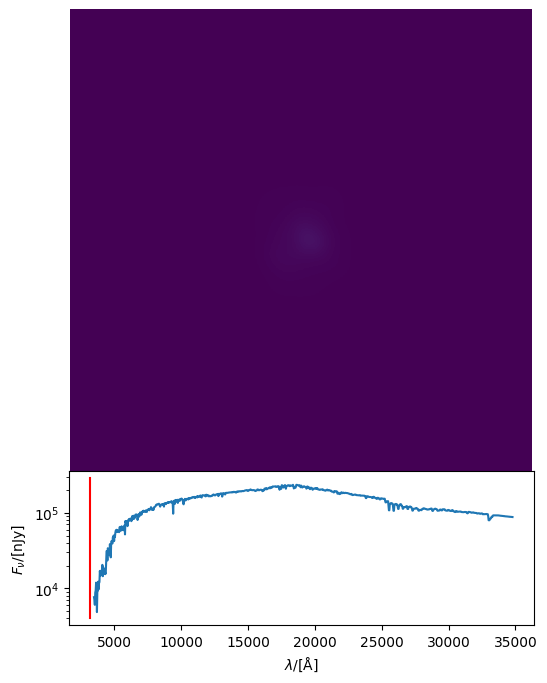

In [7]:
# Animate the data cube
ani = cube.animate_data_cube(fps=240, show=True)

### Galaxy helper method

If you don't want to use the low level `SpectralCube` object we also include a helper method on a galaxy.

In [8]:
cube = gal.get_data_cube(resolution, width, lam, cube_type="hist", stellar_spectra="intrinsic", kernel=kernel, kernel_threshold=1, quantity="flux")